In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

In [6]:
our_color_palette = {"WT": "#F2C14E", # yellow
                     "W": "#F2C14E", # yellow
                     "IP": "#79ADDC", # blue
                     "I": "#79ADDC", # blue
                     "KO": "#B279A7", # purple
                     "K": "#B279A7", # purple
                    } 
treatments_list = ["W", "I", "K"]
passages_list = ["p1", "p2", "p3", "p5", "p10"]
replicates_list = ['a', 'b', 'c']

In [7]:
# define protein 

proteins = {
"1A": (799, 1089),
    "2A": (1092, 1161),
    "2B": (1164, 1587),
    "2C": (1590, 2901),
    "3A": (2904, 3501),
    "3C": (3504, 4422),
    "RdRp": (4425, 6072),
    "VP2": (6267, 7110),
    "VP4": (7113, 7281),
    "VP3": (7284, 8175),
    "VP1": (8175, 8970),
           }

In [8]:
length_dcv = 9264

In [16]:
# load diveristy 

fname = "../../results_summary/all_snpgenie_site_results.csv"
df = pd.read_csv(fname)

In [17]:
df_pis_protein = pd.DataFrame() 

for virus in ['DCV']:
    for sample in df['passage'].unique():
        for protein in proteins.items():
            protein_id = protein[0]
            protein_start = protein[1][0]
            protein_end = protein[1][1]
            protein_length = protein_end - protein_start

            df_temp = df[df['virus']== virus]
            df_temp = df_temp[df_temp['passage']==sample]
            df_temp = df_temp[df_temp['site'].isin(list(range(protein_start,protein_end+1 )))]
            avg_pi = df_temp['pi'].sum()/protein_length

            mean_pis = {
                        'virus': [virus], 
                        'sample': sample, 
                        'protein': protein_id,
                        'avg_pi': avg_pi, 
                    }

            df_pis_protein = pd.concat([pd.DataFrame(mean_pis),df_pis_protein], ignore_index=True)

In [18]:
df_pis_protein['genotype'] = df_pis_protein['sample'].str.split("_").str[0]
df_pis_protein['rep'] = df_pis_protein['sample'].str.split("_").str[-1]
df_pis_protein['passage'] = df_pis_protein['sample'].str.split("_").str[1].str.split("p").str[-1].astype(int)

df_pis_protein.head()

,virus,sample,protein,avg_pi,genotype,rep,passage
0,DCV,W_p10_c,VP1,0.0,W,c,10
1,DCV,W_p10_c,VP3,0.0,W,c,10
2,DCV,W_p10_c,VP4,0.0,W,c,10
3,DCV,W_p10_c,VP2,0.0,W,c,10
4,DCV,W_p10_c,RdRp,0.0,W,c,10


In [19]:
df_pis_protein['genotype'].unique()

array(['W', 'I', 'K', 'parental'], dtype=object)

In [20]:
df_pis_protein = df_pis_protein[df_pis_protein['genotype']!='parental']

In [21]:
df_pi_summary = df_pis_protein[
    ['protein', 'avg_pi', 'genotype', 'passage', 'rep']
].groupby(by=['genotype', 'rep', 'protein']).mean().reset_index()

/var/folders/dw/8dl4p6h53cgcmk6cf_09v5f40000gr/T/ipykernel_6195/1048459402.py:5: FutureWarning: 

The `errwidth` parameter is deprecated. And will be removed in v0.15.0. Pass `err_kws={'linewidth': 1.1}` instead.

  g = sns.catplot(df_pi_summary,


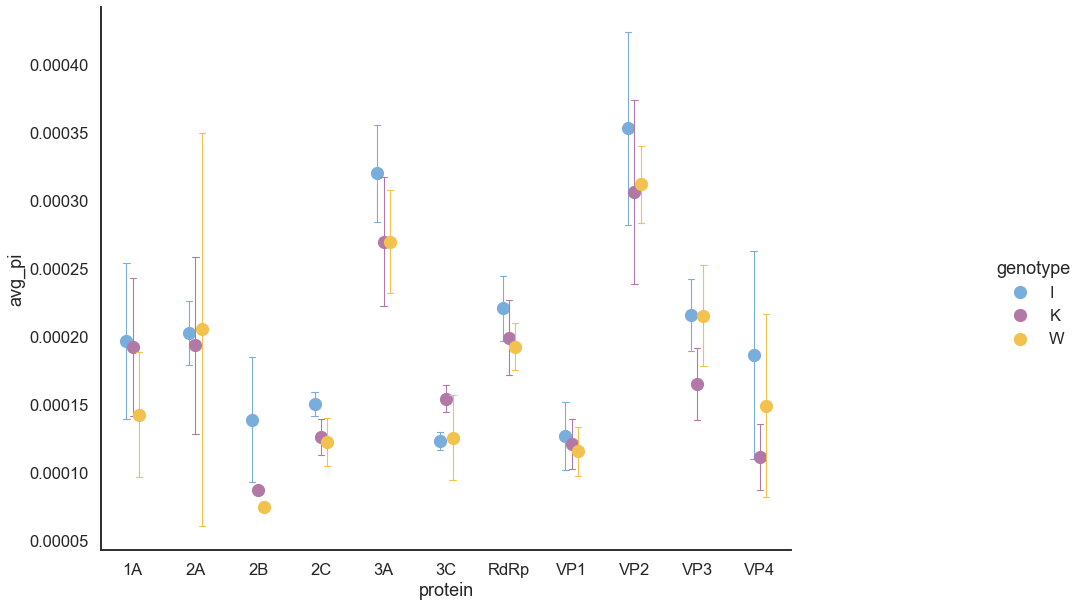

In [22]:
sns.set_context("talk") 
sns.set_style('white')


g = sns.catplot(df_pi_summary, 
                y='avg_pi',
                hue='genotype', 
                x='protein', 
                palette=our_color_palette, 
                errorbar="se",
                linestyle='',
                errwidth=1.1, 
                dodge=0.2,
                capsize=0.1,
                kind='point')

# If you need to adjust after creation, you can also use:
g.fig.set_size_inches(20, 10)



In [23]:
df_pi_summary

,genotype,rep,protein,avg_pi,passage
0,I,a,1A,0.000311,4.2
1,I,a,2A,0.000203,4.2
2,I,a,2B,0.000229,4.2
3,I,a,2C,0.000162,4.2
4,I,a,3A,0.000390,4.2
...,...,...,...,...,...
94,W,c,RdRp,0.000161,4.2
95,W,c,VP1,0.000082,4.2
96,W,c,VP2,0.000276,4.2
97,W,c,VP3,0.000142,4.2


In [24]:
%load_ext rpy2.ipython

In [36]:
%%R -i df_pi_summary 

library(rstatix)
library(ggpubr)

# Two-way mixed ANOVA test
res.aov <- anova_test(
  data = df_pi_summary, 
    dv = avg_pi, 
    wid = rep,
    between = genotype, 
    within = protein
  )
get_anova_table(res.aov)

/Users/lfuhrmann/Library/Python/3.9/lib/python/site-packages/rpy2/robjects/pandas2ri.py:54: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for name, values in obj.iteritems():
R[write to console]: Warnung:
R[write to console]:  The 'wid' column contains duplicate ids across between-subjects variables. Automatic unique id will be created



ANOVA Table (type II tests)

            Effect DFn DFd     F        p p<.05   ges
1         genotype   2   6 0.439 6.64e-01       0.040
2          protein  10  60 8.732 1.24e-08     * 0.510
3 genotype:protein  20  60 0.224 1.00e+00       0.051


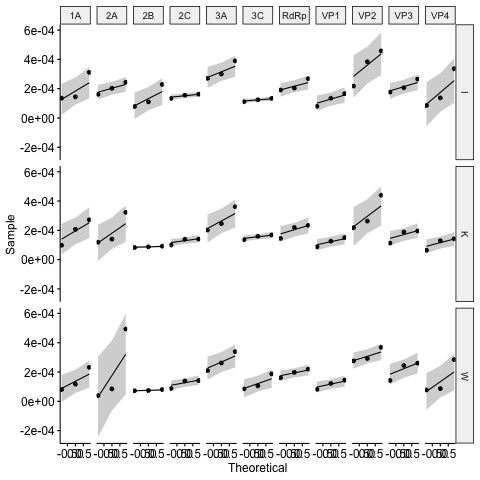

In [37]:
%%R

ggqqplot(df_pi_summary, "avg_pi")+
  facet_grid (genotype~protein)

In [38]:
%%R 

library(rstatix)
library(dplyr)
df_pi_summary %>%
  group_by(genotype) %>%
  levene_test(avg_pi~protein)

# A tibble: 3 × 5
  genotype   df1   df2 statistic     p
  <chr>    <int> <int>     <dbl> <dbl>
1 I           10    22     0.601 0.796
2 K           10    22     0.640 0.764
3 W           10    22     0.699 0.716


In [39]:
%%R 

df_pi_summary %>%
  group_by(genotype, protein) %>%
  summarise(var(avg_pi)) %>%
  as.data.frame()

`summarise()` has grouped output by 'genotype'. You can override using the
`.groups` argument.
   genotype protein  var(avg_pi)
1         I      1A 9.872875e-09
2         I      2A 1.702349e-09
3         I      2B 6.323041e-09
4         I      2C 2.304040e-10
5         I      3A 3.847400e-09
6         I      3C 1.368075e-10
7         I    RdRp 1.721629e-09
8         I     VP1 1.904604e-09
9         I     VP2 1.512495e-08
10        I     VP3 2.048185e-09
11        I     VP4 1.754014e-08
12        K      1A 7.719653e-09
13        K      2A 1.258634e-08
14        K      2B 1.929576e-11
15        K      2C 5.363527e-10
16        K      3A 6.739091e-09
17        K      3C 2.903538e-10
18        K    RdRp 2.271524e-09
19        K     VP1 1.018733e-09
20        K     VP2 1.371678e-08
21        K     VP3 2.075725e-09
22        K     VP4 1.728337e-09
23        W      1A 6.291173e-09
24        W      2A 6.256075e-08
25        W      2B 1.947042e-11
26        W      2C 9.279722e-10
27        W   

In [40]:
%%R 

box_m(df_pi_summary[ "avg_pi"], df_pi_summary$genotype)

# A tibble: 1 × 4
  statistic p.value parameter method                                            
      <dbl>   <dbl>     <dbl> <chr>                                             
1      1.33   0.514         2 Box's M-test for Homogeneity of Covariance Matric…


In [41]:
%%R

model <- aov(avg_pi ~ genotype * protein + Error(rep/protein), data = df_pi_summary)

summary(model)



Error: rep
          Df    Sum Sq   Mean Sq F value Pr(>F)
Residuals  2 6.645e-08 3.323e-08               

Error: rep:protein
          Df    Sum Sq   Mean Sq F value   Pr(>F)    
protein   10 4.342e-07 4.342e-08   13.62 7.25e-07 ***
Residuals 20 6.380e-08 3.190e-09                     
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

Error: Within
                 Df    Sum Sq   Mean Sq F value Pr(>F)
genotype          2 1.729e-08 8.643e-09   1.329  0.275
genotype:protein 20 2.230e-08 1.115e-09   0.172  1.000
Residuals        44 2.861e-07 6.503e-09               


In [43]:
%%R 

library(emmeans)

# Assuming your contrasts are stored in a data frame called 'contrasts'
# If not, first convert the emmeans output to a data frame
contrasts_df <- as.data.frame(pairs(emmeans(model, ~ protein)))

# Filter significant contrasts
significant_contrasts <- contrasts_df[contrasts_df$p.value < 0.05, ]

# Sort by p-value
significant_contrasts <- significant_contrasts[order(significant_contrasts$p.value), ]

# Display results
print(significant_contrasts)

R[write to console]: Note: re-fitting model with sum-to-zero contrasts

R[write to console]: NOTE: Results may be misleading due to involvement in interactions



 contrast        estimate           SE df t.ratio p.value
 2B - VP2   -2.234984e-04 2.661921e-05 20  -8.396  <.0001
 VP1 - VP2  -2.026448e-04 2.661921e-05 20  -7.613  <.0001
 2C - VP2   -1.909305e-04 2.661921e-05 20  -7.173  <.0001
 3C - VP2   -1.894309e-04 2.661921e-05 20  -7.116  <.0001
 2B - 3A    -1.861319e-04 2.661921e-05 20  -6.992  <.0001
 VP2 - VP4   1.748386e-04 2.661921e-05 20   6.568  0.0001
 3A - VP1    1.652784e-04 2.661921e-05 20   6.209  0.0002
 2C - 3A    -1.535641e-04 2.661921e-05 20  -5.769  0.0005
 3A - 3C     1.520645e-04 2.661921e-05 20   5.713  0.0005
 1A - VP2   -1.467005e-04 2.661921e-05 20  -5.511  0.0008
 3A - VP4    1.374722e-04 2.661921e-05 20   5.164  0.0018
 VP2 - VP3   1.249498e-04 2.661921e-05 20   4.694  0.0050
 2A - VP2   -1.232598e-04 2.661921e-05 20  -4.630  0.0058
 RdRp - VP2 -1.196422e-04 2.661921e-05 20  -4.495  0.0078
 1A - 3A    -1.093341e-04 2.661921e-05 20  -4.107  0.0178
 2B - RdRp  -1.038561e-04 2.661921e-05 20  -3.902  0.0276
 2A - 2B     1